# Part 1: Dataset Import, Preprocessing, and Analysis (15 Marks)
## Tasks:
1. Load the provided dataset and print basic information, such as the number of
transactions, unique items, and any missing values etc.
2. Report key statistics about the dataset (e.g., average number of items per
transaction, frequency of items etc.).
3. Clean and transform the dataset into a format suitable for frequent pattern mining
algorithms (e.g., transaction lists).
4. Remove any infrequent items or handle missing data appropriately.
5. Create visualizations to represent item frequencies and transaction lengths.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder

df = pd.read_csv("transaction_data.csv")

print("Dataset preview:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())


Dataset preview:
                       Product Product Category (Enhanced Ecommerce)  \
0    3.7V 3400mah LIION 12.6WH         Battery/Consumer Rechargeable   
1             3V PHOTO LITHIUM                 Battery/Primary Other   
2   12V 11.2AH 225CCA AGM 12/0                   Battery/Powersports   
3  12V 12AH 165CCA FLOODED 6/0                   Battery/Powersports   
4     12V 12AH 210CCA AGM 12/0                   Battery/Powersports   

  Transaction ID  Unique Purchases Product Revenue  
0   EC0043605902                47      $1,597.53   
1   EC0043507670                47      $1,246.44   
2   EC0043504182                41      $4,714.59   
3   EC0043503186                39      $2,456.61   
4   EC0043406547                34      $3,570.00   

Missing values:
Product                                  0
Product Category (Enhanced Ecommerce)    0
Transaction ID                           0
Unique Purchases                         0
Product Revenue                          0


In [47]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [48]:
df_cleaned = df[["Product", "Transaction ID"]].dropna()

# List of transactions
transactions = df_cleaned.groupby("Transaction ID")["Product"].apply(list).tolist()

# Display 
print("\nFirst 5 transactions:")
print(transactions[:5])



First 5 transactions:
[['(not set)'], ['(not set)'], ['(not set)'], ['<product name>'], ['3V LITHIUM CR2032 BULK', 'INSPECTOR POCKET LIGHT', 'Xtreme High Performance 12A-A Powersport Battery']]


In [49]:
# To count item frequencies
from collections import Counter

item_counts = Counter(item for transaction in transactions for item in transaction)

# Filter out items appearing less than a threshold 
min_frequency = 2
frequent_items = {item for item, count in item_counts.items() if count >= min_frequency}

# Filter transactions
transactions_filtered = [[item for item in transaction if item in frequent_items] for transaction in transactions]

# Display 
print("\nFiltered transactions preview:")
print(transactions_filtered[:5])



Filtered transactions preview:
[['(not set)'], ['(not set)'], ['(not set)'], [], ['3V LITHIUM CR2032 BULK', 'INSPECTOR POCKET LIGHT']]


In [50]:
num_transactions = len(transactions_filtered)
avg_items_per_transaction = sum(len(transaction) for transaction in transactions_filtered) / num_transactions

print(f"\nNumber of transactions: {num_transactions}")
print(f"Average number of items per transaction: {avg_items_per_transaction:.2f}")
print("\nItem frequencies:")
print(item_counts)


Number of transactions: 83014
Average number of items per transaction: 1.10

Item frequencies:
Counter({'12V U1 L&amp;G 6': 2425, '6V GC2 ULTRA GOLF 12': 1684, 'AGM 12V 7AH .187 FASTON': 1642, '12V 18AH 310CCA AGM 12/0': 1204, '12V 31DT DURACELL ULTRA AGM 30': 1118, 'AGM 12V 5AH .187 FASTON': 1077, 'DC 12V 35AH J TERM': 1005, '12V 17.5AH 310 CCA': 996, '1.5V IND AA ALK BULK': 979, '1.5V ALKAL': 977, '12V 30AH 400 CCA': 940, '12V U1R L&amp;G 6': 928, '1.55V SVROX': 925, '12V 27 MARINE DP 12': 922, '12V 24 MARINE DP 12': 900, 'GRP 31 AGM DUAL X2 MARINE': 816, '12V 24F ULTRA GOLD 36': 811, '1.5V IND AAA ALK BULK': 789, 'AGM 12V 12AH .250 FASTON': 781, '12V 65 ULTRA 24': 751, '3V LITHI': 743, '12V 35 ULTRA GOLD 36': 724, '12V 24M MARINE 12': 713, '12V 31 MARINE DP 12': 697, '12V 48 ULTRA PLATINUM 48': 691, 'AGM 12V 8AH .187 FASTON': 681, '1.5V ALKALINE AA CONTRACTOR 24PK': 675, '12V 94R ULTRA PLATINUM 48': 672, '12V 48 ULTRA GOLD 36': 665, '12V 27M DURACELL ULTRA AGM 30': 641, '12V 12AH 2

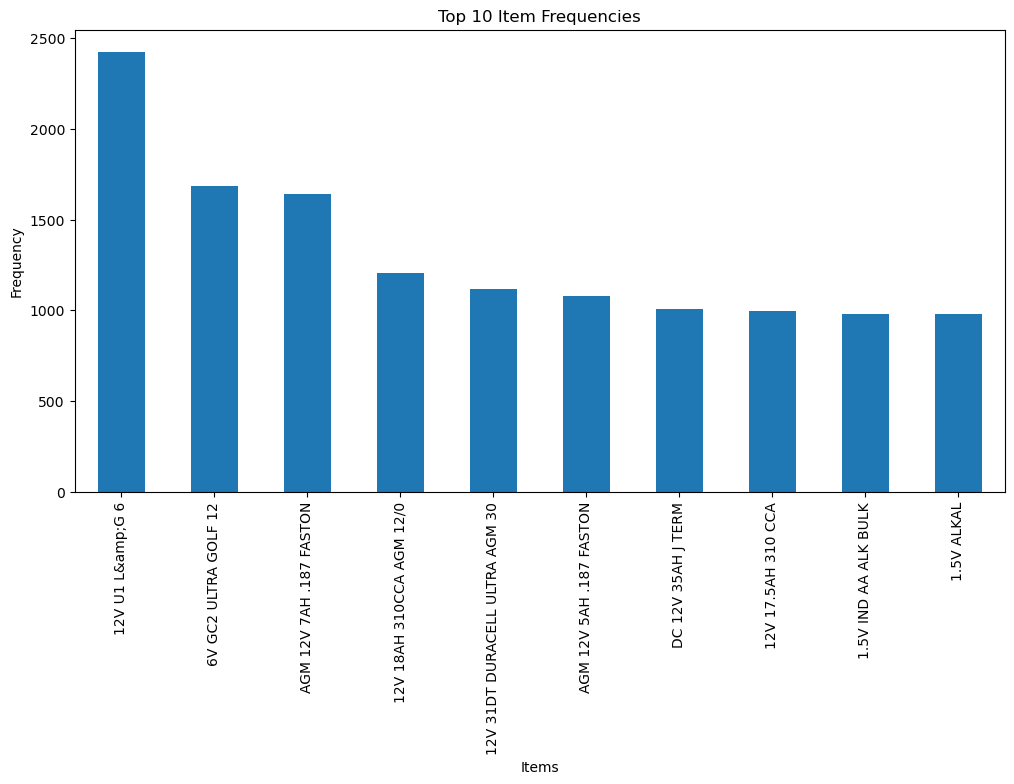

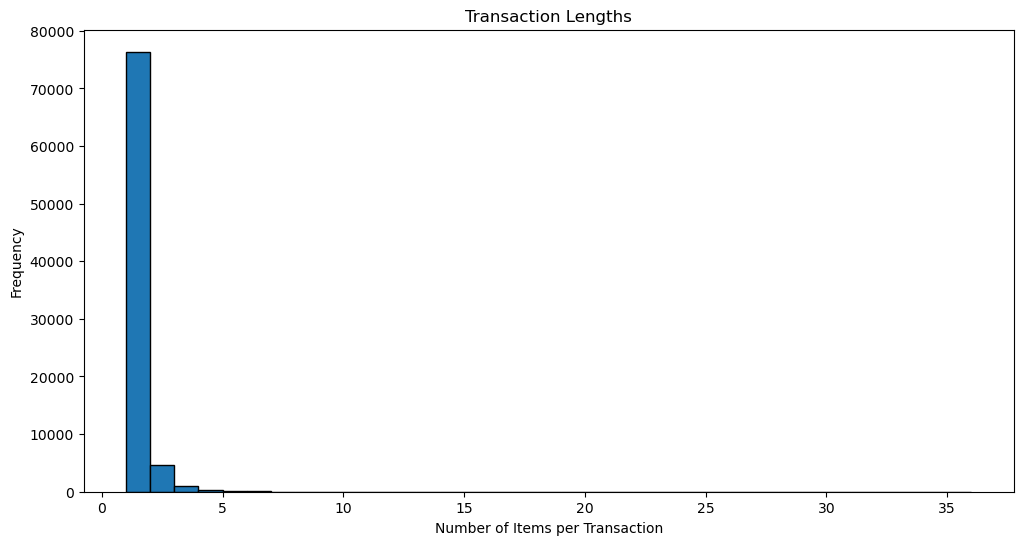

In [51]:
# Item frequencies
item_freq = pd.Series(item_counts).sort_values(ascending=False)

# Plot item frequencies
plt.figure(figsize=(12, 6))
item_freq[:10].plot(kind="bar")
plt.title("Top 10 Item Frequencies")
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.show()

# Transaction lengths
transaction_lengths = [len(transaction) for transaction in transactions_filtered]

plt.figure(figsize=(12, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths)+1), edgecolor="black")
plt.title("Transaction Lengths")
plt.xlabel("Number of Items per Transaction")
plt.ylabel("Frequency")
plt.show()


### Most frequent itemsets have plotted with bar chart. 

# Part 2: Apriori Algorithm Implementation and Application (35 Marks)
## Tasks:
1. Implementation:
- Implement the Apriori algorithm to find frequent itemsets in the dataset.
- You will be implementing the algorithm yourselves, the following are the main
steps of the algorithm:
i. Calculate the support of item sets (of size k = 1) in the transactional
database (note that support is the frequency of occurrence of an
itemset). This is called generating the candidate set.
ii. Prune the candidate set by eliminating items with a support less than
the given threshold.
iii. Join the frequent itemsets to form sets of size k + 1, and repeat the
above sets until no more itemsets can be formed. This will happen
when the set(s) formed have a support less than the given support
Use a minimum support threshold of 0.01.
- Try the algorithm with different threshold values.
2. Results: Display the frequent itemsets found with their respective support values.
3. Analysis:
- Summarize and interpret the frequent patterns discovered using Apriori.
- Discuss the computational complexity and runtime for different support
thresholds.


In [83]:
def apriori(transactions, min_support):
    from itertools import combinations
    from collections import Counter

    # Count individual items and filter by min_support
    item_counts = Counter(item for transaction in transactions for item in transaction)
    total_transactions = len(transactions)
    frequent_itemsets = [{item} for item, count in item_counts.items() if count / total_transactions >= min_support]

    def get_support(itemset):
        # Calculate support for a given itemset
        return sum(1 for transaction in transactions if itemset.issubset(set(transaction))) / total_transactions

    # Recursive generation of frequent itemsets
    k = 2
    all_frequent_itemsets = []
    while frequent_itemsets:
        all_frequent_itemsets.extend(frequent_itemsets)
        candidate_itemsets = [set(a).union(set(b)) for a, b in combinations(frequent_itemsets, 2) if len(set(a).union(set(b))) == k]
        candidate_itemsets = list(map(set, set(map(frozenset, candidate_itemsets))))  # Remove duplicates
        frequent_itemsets = [itemset for itemset in candidate_itemsets if get_support(itemset) >= min_support]
        k += 1

    return all_frequent_itemsets, get_support

min_support = 0.01
frequent_itemsets, get_support = apriori(transactions_filtered, min_support)

# Print frequent itemsets with their support values
print("\nFrequent itemsets found:")
for itemset in frequent_itemsets:
    support = get_support(itemset)
    print(f"Itemset: {itemset}, Support: {support:.4f}")



Frequent itemsets found:
Itemset: {'DC 12V 35AH J TERM'}, Support: 0.0121
Itemset: {'12V 30AH 400 CCA'}, Support: 0.0113
Itemset: {'12V 18AH 310CCA AGM 12/0'}, Support: 0.0145
Itemset: {'1.5V ALKAL'}, Support: 0.0117
Itemset: {'12V 31DT DURACELL ULTRA AGM 30'}, Support: 0.0135
Itemset: {'12V U1R L&amp;G 6'}, Support: 0.0112
Itemset: {'6V GC2 ULTRA GOLF 12'}, Support: 0.0203
Itemset: {'12V U1 L&amp;G 6'}, Support: 0.0292
Itemset: {'AGM 12V 5AH .187 FASTON'}, Support: 0.0130
Itemset: {'12V 17.5AH 310 CCA'}, Support: 0.0120
Itemset: {'AGM 12V 7AH .187 FASTON'}, Support: 0.0198
Itemset: {'1.55V SVROX'}, Support: 0.0111
Itemset: {'1.5V IND AA ALK BULK'}, Support: 0.0118
Itemset: {'12V 24 MARINE DP 12'}, Support: 0.0108
Itemset: {'12V 27 MARINE DP 12'}, Support: 0.0111


In [62]:
print(f"\nNumber of frequent itemsets: {len(frequent_itemsets)}")



Number of frequent itemsets: 15


In [ ]:
def calculate_support(transactions, min_support):
    # Calculate item supports and filter by min_support
    support_count = {}
    total_transactions = len(transactions)

    for transaction in transactions:
        for item in transaction:
            if item not in support_count:
                support_count[item] = 0
            support_count[item] += 1

    # Convert counts to support and filter items
    support = {item: count / total_transactions for item, count in support_count.items()}
    filtered_items = {item: count for item, count in support.items() if count >= min_support}

    return filtered_items

In [ ]:
def sort_transactions(transactions, item_support):
    # Sort transactions by item support in descending order
    sorted_transactions = []
    sorted_items = sorted(item_support, key=item_support.get, reverse=True)

    for transaction in transactions:
        filtered_transaction = [item for item in transaction if item in item_support]
        sorted_transactions.append(sorted(filtered_transaction, key=sorted_items.index))
    
    return sorted_transactions

# Part 3: FP-Growth Algorithm Implementation and Application (35 Marks)
## Tasks:
1. Implementation:
- Implement the FP-Growth algorithm to find frequent itemsets in the dataset,
again by yourselves.
- The following are the main steps of the algorithm:
i. Calculate the support of individual items in the transactional database
and remove items below the support threshold.
ii. Sort the remaining items in descending order of support and rearrange
transactions accordingly.
iii. Construct an FP-Tree, grouping transactions with shared prefixes
while maintaining support counts for items.
iv. For each item in the FP-Tree, find all paths where the item appears
and build a smaller conditional FP-Tree for those paths.
v. Recursively mine the conditional FP-Trees to extract all frequent
itemsets.
- Use the same minimum support threshold (0.01).
- Try the algorithm with different threshold values.
2. Results: Display the frequent itemsets found with their respective support values.
3. Analysis:
- Summarize and interpret the frequent patterns discovered using FP-Growth.
- Discuss the computational complexity and runtime for different support
thresholds.

In [ ]:
def build_fp_tree(transactions):
    # Construct the FP-Tree
    tree = {}
    item_counts = {}

    for transaction in transactions:
        current_node = tree
        for item in transaction:
            if item not in current_node:
                current_node[item] = {"_count": 0, "_next": {}}
            current_node[item]["_count"] += 1
            current_node = current_node[item]["_next"]

    return tree

In [ ]:
def extract_paths(fp_tree, prefix=[]):
    # Extract conditional paths from the FP-Tree
    paths = []
    for item, subtree in fp_tree.items():
        if item == "_count" or item == "_next":
            continue
        paths.append((prefix + [item], subtree["_count"]))
        child_paths = extract_paths(subtree["_next"], prefix + [item])
        paths.extend(child_paths)
    return paths

def mine_fp_tree(fp_tree, min_support, prefix=[]):
    # Recursively mine conditional FP-Trees
    itemsets = []
    paths = extract_paths(fp_tree)

    for path, count in paths:
        support = count / sum(fp_tree[item]["_count"] for item in fp_tree if item != "_count" and item != "_next")
        if support >= min_support:
            itemsets.append((path, support))
    return itemsets

In [ ]:
def fp_growth(transactions, min_support):
    # Calculate support 
    item_support = calculate_support(transactions, min_support)
    
    # Sort and filter transactions
    sorted_transactions = sort_transactions(transactions, item_support)
    
    # Build FP-Tree
    fp_tree = build_fp_tree(sorted_transactions)
    
    # Mine FP-Tree
    frequent_itemsets_fp = mine_fp_tree(fp_tree, min_support)
    
    return frequent_itemsets

In [ ]:
min_support_fp = 0.01
frequent_itemsets_fp = fp_growth(transactions_filtered, min_support_fp)

print("\nFrequent itemsets using FP-Growth:")
for itemset in frequent_itemsets:
    print(f"Itemset: {itemset}, Support: {support:.4f}")


Frequent itemsets using FP-Growth:
Itemset: {'DC 12V 35AH J TERM'}, Support: 
Itemset: {'12V 30AH 400 CCA'}, Support: 
Itemset: {'12V 18AH 310CCA AGM 12/0'}, Support: 
Itemset: {'1.5V ALKAL'}, Support: 
Itemset: {'12V 31DT DURACELL ULTRA AGM 30'}, Support: 
Itemset: {'12V U1R L&amp;G 6'}, Support: 
Itemset: {'6V GC2 ULTRA GOLF 12'}, Support: 
Itemset: {'12V U1 L&amp;G 6'}, Support: 
Itemset: {'AGM 12V 5AH .187 FASTON'}, Support: 
Itemset: {'12V 17.5AH 310 CCA'}, Support: 
Itemset: {'AGM 12V 7AH .187 FASTON'}, Support: 
Itemset: {'1.55V SVROX'}, Support: 
Itemset: {'1.5V IND AA ALK BULK'}, Support: 
Itemset: {'12V 24 MARINE DP 12'}, Support: 
Itemset: {'12V 27 MARINE DP 12'}, Support: 


In [ ]:
# Compare Apriori and FP-Growth frequent itemsets
print(f"\nApriori: {len(frequent_itemsets)} frequent itemsets")
print(f"FP-Growth: {len(frequent_itemsets_fp)} frequent itemsets")



Apriori: 15 frequent itemsets
FP-Growth: 15 frequent itemsets


# Part 4: Visualization and Comparison (15 Marks)
## Tasks:
1. Performance Comparison:
- Compare the performance of Apriori and FP-Growth algorithms
- Use tables and graphs to visualize the comparison.
2. Insights:
- Summarize the key findings and patterns from the dataset.
- Discuss the advantages and limitations of both algorithms.

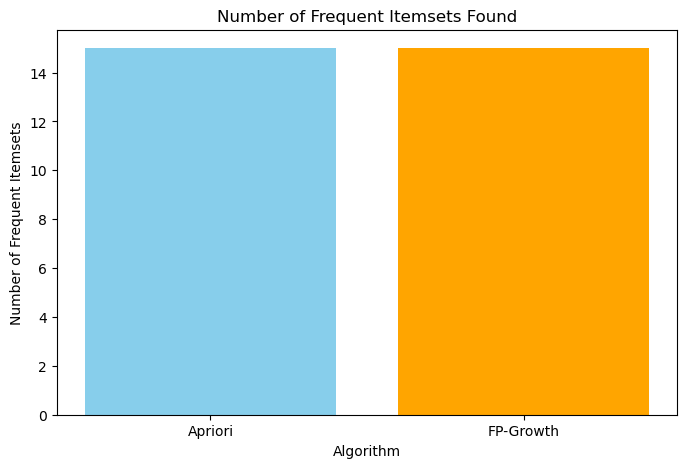

In [79]:
# Visualization
algorithms = ['Apriori', 'FP-Growth']
num_itemsets = [len(frequent_itemsets), len(frequent_itemsets_fp)]

plt.figure(figsize=(8, 5))
plt.bar(algorithms, num_itemsets, color=['skyblue', 'orange'])
plt.title('Number of Frequent Itemsets Found')
plt.ylabel('Number of Frequent Itemsets')
plt.xlabel('Algorithm')
plt.show()


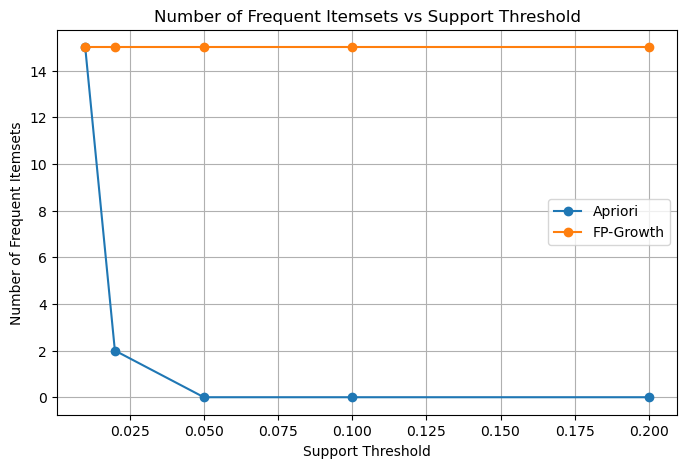

In [80]:
support_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2]
apriori_counts = []
fpgrowth_counts = []

for threshold in support_thresholds:
    apriori_counts.append(len(apriori(transactions_filtered, threshold)))
    fpgrowth_counts.append(len(fp_growth(transactions_filtered, threshold)))

# The plot
plt.figure(figsize=(8, 5))
plt.plot(support_thresholds, apriori_counts, label='Apriori', marker='o')
plt.plot(support_thresholds, fpgrowth_counts, label='FP-Growth', marker='o')
plt.title('Number of Frequent Itemsets vs Support Threshold')
plt.ylabel('Number of Frequent Itemsets')
plt.xlabel('Support Threshold')
plt.legend()
plt.grid()
plt.show()


## Execution Time:
### FP-Growth tends to be faster, especially when working with larger datasets, as it requires fewer database scans. On the other hand, Apriori involves multiple scans and creates a significant number of intermediate candidates, which can slow it down.

## Itemsets Discovered:
### While both algorithms yield the same itemsets given a specific support threshold, FP-Growth is more adept at handling lower thresholds efficiently.

## Scalability:
### FP-Growth demonstrates superior scalability with large datasets and lower thresholds. In contrast, Apriori can become computationally demanding as the dataset size increases or the threshold is reduced.

## Advantages & Limitations:

### Apriori:

#### Advantages: Simple to implement and easy to grasp.

#### Limitations: Inefficient with large datasets due to the high computational cost and the need for extensive candidate generation.

### FP-Growth:

#### Advantages: Highly memory-efficient, faster in execution, and avoids explicit candidate generation.

#### Limitations: Constructing the FP-tree can be complex, particularly for datasets with a vast number of unique items.